# Interaction models data convergence
How fast do models converge? With interaction terms, a more complex model should take longer to converge.
Can we show this by training against different data lengths.

Can we get the best of both worlds by converging the main effects fast, and then introduce complexity when needed?

Start by importing stuff:

In [1]:
import pandas as pd
import polars as pl

import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use("seaborn-whitegrid")


/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_68237/563970410.py:7: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use("seaborn-whitegrid")


Let's generate some data.
We will generate some linear data and include interaction terms.

Data is generated as follows:

In [2]:
import numpy as np
import sklearn.preprocessing

RND = np.random.default_rng(0)

def gen_data(
    n: int = 100_000,
    x_dim: int = 6,
    noise_level: float = 2.0,
    interaction_scale:float =0.01
):

    # base features
    x_base = pd.DataFrame(RND.uniform(-1, 1, size=(n, x_dim)))

    # add interactions
    int_trans = sklearn.preprocessing.PolynomialFeatures(
        interaction_only=True, degree=2, include_bias=False
    ).set_output(transform="pandas")
    x = int_trans.fit_transform(x_base)

    # make weights
    bias = RND.uniform(-1, 1, size=(1))
    w = RND.uniform(-1, 1, size=(x.shape[1]))
    # scale interaction weights
    w[x_dim:] = interaction_scale * w[x_dim:]

    # make outcomes
    z = np.dot(x, w)
    y = bias + z + noise_level * RND.normal(size=(n))

    return x, y, w, bias, z

n = 100_000
x_dim = 6
x, y, w, bias, z = gen_data(n=n, x_dim=x_dim)

## Train models

Split train/test

In [3]:
x_train = x[: n // 2]
x_test = x[n // 2 :]
y_train = y[: n // 2]
y_test = y[n // 2 :]


## Model coefficient comparisons

If we want to train with just updates and not from scratch we can use models such as stochastic gradient descent or Bayesian linear regression.


In [9]:
model_coefs = {}

Statsmodels with act as the oracle

In [10]:
import statsmodels.api as sm
model_sm = sm.OLS(y_train, x_train).fit()
model_coefs['stats_models'] = model_sm.params.to_numpy()

Check partial fit is equal to full fit

we observe slightly different coefficients. Probably not a big enough concern though.

In [11]:
import sklearn.linear_model

model_sgd = sklearn.linear_model.SGDRegressor(penalty=None)
model_sgd.partial_fit(X=x_train, y=y_train)

model_lin = sklearn.linear_model.LinearRegression()
model_lin.fit(X=x_train, y=y_train)


model_coefs['sk_lin_reg'] = model_lin.coef_
model_coefs['sk_sgd_reg'] = model_sgd.coef_

Bayesian regression class

More details on this model can be found [here](https://github.com/stanton119/data-analysis/blob/master/SequentialBayesianRegression/sequential_bayesian_linear_regression.ipynb).

In [51]:
class BayesLinearRegressor:
    def __init__(
        self, number_of_features, mean=None, cov=None, alpha=1e6, beta=1
    ):
        # prior distribution on weights
        if mean is None:
            self.mean = np.array([[0] * (number_of_features)], dtype=float).T

        if cov is None:
            self.cov = alpha * np.identity(number_of_features)
            self.cov_inv = np.linalg.inv(self.cov)
            self.cov_init = self.cov

        self.beta = beta  # process noise
        self.number_of_features = number_of_features

    def fit(self, X, y):
        return self.update(X, y)

    def update(self, X, y, inc_alpha=None):
        """
        Perform a bayesian update step
        """
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if len(X.shape) == 1:
            X = X[np.newaxis, :]
        if len(y.shape) == 1:
            y = y[:, np.newaxis]
        if X.shape[1]>self.number_of_features:
            X = X[:, :self.number_of_features]

        # update state of covariance and means
        cov_n_inv = self.cov_inv + self.beta * X.T @ X
        cov_n = np.linalg.inv(cov_n_inv)
        mean_n = cov_n @ (self.cov_inv @ self.mean + self.beta * X.T @ y)

        if inc_alpha is not None:
            # cov_n = cov_n - (cov_n - self.cov_init) * inc_alpha
            cov_n = cov_n + inc_alpha * np.identity(self.number_of_features)

            cov_n_inv = np.linalg.inv(cov_n)


        self.cov_inv = cov_n_inv
        self.cov = cov_n
        self.mean = mean_n

    def predict(self, X)->[np.array,np.array]:
        if isinstance(X, pd.DataFrame):
            X = X.to_numpy()
        if X.shape[1]>self.number_of_features:
            X = X[:, :self.number_of_features]

        mean = X @ self.mean
        if X.shape[0]<1_000:
            scale = np.sqrt(np.sum(X @ self.cov @ X.T, axis=1))
        else:
            scale = None
        return mean, scale

    @property
    def coef_(self):
        return self.mean.flatten()

    @property
    def scale_(self):
        return np.sqrt(np.diag(self.cov))
    
    @staticmethod
    def callback(model)->dict:
        return {'coef':model.coef_, 'scale':model.scale_}

bayes_linear_regression = BayesLinearRegressor(number_of_features=x_train.shape[1])
bayes_linear_regression.fit(X=x_train, y=y_train)
model_coefs['bayes'] = bayes_linear_regression.coef_

Plotting the results shows in this case the bayes rule based model tracks stats models better than the SGD regressor.

/var/folders/_v/nlh4h1yx2n1gd6f3szjlgxt40000gr/T/ipykernel_68237/1229441813.py:4: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


,stats_models,sk_lin_reg,sk_sgd_reg,bayes
0,0.659756,0.667925,0.687262,0.659756
1,-0.352047,-0.368236,-0.349077,-0.352047
2,0.638362,0.632207,0.638644,0.638362
3,-0.030513,-0.030132,-0.031297,-0.030513
4,-0.393761,-0.402386,-0.375550,-0.393761
5,0.559838,0.564904,0.571385,0.559838
6,-0.000705,-0.002319,0.028070,-0.000705
7,-0.009047,-0.005490,-0.051229,-0.009047
8,-0.029508,-0.024574,-0.026776,-0.029508
9,-0.027805,-0.029587,-0.020650,-0.027805


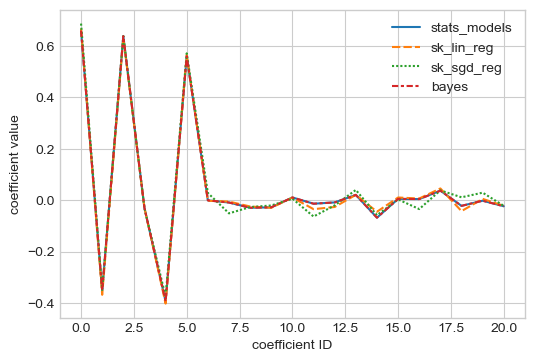

In [43]:
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=pd.DataFrame(model_coefs), ax=ax)
ax.set(ylabel="coefficient value", xlabel="coefficient ID")
fig.show()

display(pd.DataFrame(model_coefs))


# TODO

* Test each iteration

Model options
* Fit base effects model, use coefficients as priors in an interaction model
* Interactions model with tight priors on interaction terms

## Partial fit refactor
Partially training Bayes rule based model

Train a model with a batch of data.
Predict outcomes
Return model/coefficients
Find metrics
repeat over N batches

Keeping predictions is costly if many batches.


In [174]:
def evaluate_batches(
    x_train: np.array,
    y_train: np.array,
    x_test: np.array,
    y_test: np.array,
    model,
    metric_callback,
    model_callback=None,
    no_batches: int = 1000,
) -> [dict[int, any], dict[int, any]]:
    metrics = {}
    models_details = {}
    # batch_blocks = np.arange(0, x_train.shape[0], step=batch_size)
    batch_blocks = np.unique(
        np.clip(
            np.logspace(1, np.ceil(np.log10(x_train.shape[0])), no_batches).astype(int),
            1,
            x_train.shape[0],
        )
    )

    # range_obj = tqdm.trange(len(batch_blocks) - 1)
    range_obj = range(len(batch_blocks) - 1)
    for _id in range_obj:
        model.update(
            x_train[batch_blocks[_id] : batch_blocks[_id + 1]],
            y_train[batch_blocks[_id] : batch_blocks[_id + 1]],
        )
        y_est = model.predict(x_test)[0]
        metrics[batch_blocks[_id]] = metric_callback(y_est=y_est, y_test=y_test)
        if model_callback is not None:
            models_details[batch_blocks[_id]] = model_callback(model)
    return metrics, models_details


def get_metrics(y_est, y_test) -> dict:
    metrics = {}
    metrics["mse"] = sklearn.metrics.mean_squared_error(y_test, y_est)

    return metrics


x, y, w, bias, z = gen_data(n=n, x_dim=x_dim, interaction_scale=2.0)

x_train = x[: n // 2]
x_test = x[n // 2 :]
y_train = y[: n // 2]
y_test = y[n // 2 :]
metrics, models_details = evaluate_batches(
    x_train=x_train,
    y_train=y_train,
    x_test=x_test,
    y_test=y_test,
    model=BayesLinearRegressor(number_of_features=x_dim),
    metric_callback=get_metrics,
    model_callback=BayesLinearRegressor.callback,
    no_batches=1000,
)

Train multiple models

In [175]:
def train_loop(n: int = 100_000, x_dim: int = 6, interaction_scale: float = 0.01):
    x, y, w, bias, z = gen_data(n=n, x_dim=x_dim, interaction_scale=interaction_scale)

    x_train = x[: n // 2]
    x_test = x[n // 2 :]
    y_train = y[: n // 2]
    y_test = y[n // 2 :]

    models = {
        'base':BayesLinearRegressor(number_of_features=x_dim),
        'pair_int':BayesLinearRegressor(number_of_features=x_train.shape[1])
    }


    metrics= {}
    models_details = {}
    for _name, _model in models.items():
        _metrics, _models_details = evaluate_batches(
            x_train=x_train,
            y_train=y_train,
            x_test=x_test,
            y_test=y_test,
            model=_model,
            metric_callback=get_metrics,
            model_callback=BayesLinearRegressor.callback,
            no_batches=1000,
        )
        metrics[_name] = _metrics
        models_details[_name] = _models_details
    
    return metrics, models_details

_ = train_loop()

Bootstrap

In [184]:
loop_outputs = []
for _i in tqdm.trange(10):
    _metrics, _models_details = train_loop(n = 10_000, x_dim = 6, interaction_scale = 0.01)
    loop_outputs.append((_metrics, _models_details))


100%|██████████| 10/10 [00:02<00:00,  4.86it/s]


In [182]:
metrics[20][0]

{'base': {1: {'mse': 5.629863192255653},
  2: {'mse': 5.9813299703237455},
  3: {'mse': 6.101146703181418},
  4: {'mse': 6.1608711448420985},
  5: {'mse': 13.074711903448094},
  6: {'mse': 23.67952167225019},
  7: {'mse': 16.273880707802526},
  8: {'mse': 7.899207615217846},
  9: {'mse': 7.902259601977735},
  10: {'mse': 7.914274836109383},
  11: {'mse': 7.24412058159492},
  12: {'mse': 6.969007005234578},
  13: {'mse': 6.819956650064391},
  14: {'mse': 6.5872134325637175},
  15: {'mse': 6.4403116091690364},
  16: {'mse': 6.620964435446213},
  17: {'mse': 6.277263883040482},
  18: {'mse': 6.343872812676139},
  19: {'mse': 6.209852269433669},
  20: {'mse': 6.571962470933846},
  21: {'mse': 6.6016502512312885},
  22: {'mse': 6.550725795126507},
  23: {'mse': 6.43065522876165},
  24: {'mse': 6.538633531501436},
  25: {'mse': 6.53461991030232},
  26: {'mse': 6.455997724620422},
  27: {'mse': 6.375726830927103},
  28: {'mse': 6.375076971233236},
  29: {'mse': 6.403493781949279},
  30: {'mse

In [ ]:
metrics = pl.concat(metrics)

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    data=metrics.melt(id_vars="data_size"),
    x="data_size",
    y="value",
    hue="variable",
    ax=ax,
)
ax.set_xscale("log")
ax.set_yscale("log")
fig.show()


In [160]:
metrics

{'base': {1: {'mse': 7.2300928764631855},
  2: {'mse': 10.999905147941536},
  3: {'mse': 16.16701241620968},
  4: {'mse': 16.375345073121075},
  5: {'mse': 39.83866576242278},
  6: {'mse': 43.36405915915135},
  7: {'mse': 43.34264051598723},
  8: {'mse': 40.56105713113671},
  9: {'mse': 40.52499189310843},
  10: {'mse': 21.986993582319016},
  11: {'mse': 22.177823168669462},
  12: {'mse': 20.761492996169025},
  13: {'mse': 19.886310997895066},
  14: {'mse': 19.50873276506549},
  15: {'mse': 18.778370481508553},
  16: {'mse': 12.939574632709537},
  17: {'mse': 13.272767566358592},
  18: {'mse': 13.460054389058225},
  19: {'mse': 13.343060720016654},
  20: {'mse': 12.201678995697836},
  21: {'mse': 11.313092853358176},
  22: {'mse': 10.71349272820568},
  23: {'mse': 11.181758094630542},
  24: {'mse': 10.87792387021906},
  25: {'mse': 10.703877377616266},
  26: {'mse': 10.639111016487142},
  27: {'mse': 10.011690600986867},
  28: {'mse': 9.913982093448286},
  29: {'mse': 9.780937077520507

Plot metrics

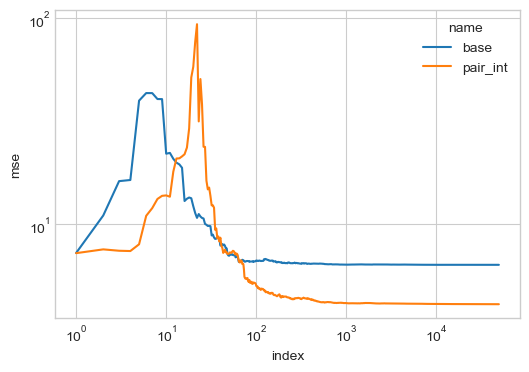

In [141]:
metrics_df = pd.concat(
    [
        pd.DataFrame.from_dict(_metrics, orient="index")
        .assign(name=_name)
        .reset_index()
        for _name, _metrics in metrics.items()
    ]
)
metrics_df

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=metrics_df, x="index", y="mse", hue="name", ax=ax)
ax.set_xscale("log")
ax.set_yscale("log")


Plot coefficients

In [147]:
_models_details

{1: {'coef': array([ 0.15718073,  0.13806928,  0.01562964, -0.10710731,  0.23826393,
         -0.10381052, -0.07792836, -0.0088216 ,  0.06045297, -0.13447972,
          0.05859221, -0.00774899,  0.05310255, -0.11812847,  0.05146804,
          0.00601128, -0.01337231,  0.00582625,  0.09163822, -0.03992636,
          0.08881757]),
  'scale': array([933.43555104, 949.04995081, 999.3635277 , 969.65965412,
         839.21012069, 971.525655  , 984.05550503, 999.79728667,
         990.43553663, 951.7311363 , 991.01789722, 999.84358882,
         992.62812427, 962.96867665, 993.07651511, 999.90587643,
         999.5341378 , 999.91158181, 977.88300383, 995.83929149,
         979.23780708])},
 2: {'coef': array([ 0.6104512 , -0.09097631, -0.79462829, -1.13518344, -0.43970807,
         -0.90070401, -0.02598156,  0.25925328,  0.42322951,  0.04967206,
          0.34349855, -0.29245139, -0.22603111, -0.50199987, -0.15145114,
         -0.77314794, -0.73915066, -0.58385968, -0.65951667, -0.75372905,
  

In [146]:
# outcome df
# batch_size, name, coef_id, mean, scale


models_details_df = pd.concat(
    [
        pd.DataFrame.from_dict(_models_details, orient="index")
        .assign(name=_name)
        .reset_index()
        for _name, _models_details in models_details.items()
    ]
)
models_details_df

# fig, ax = plt.subplots(figsize=(6, 4))
# sns.lineplot(data=models_details_df, x="index", y="mse", hue="name", ax=ax)
# ax.set_xscale("log")
# ax.set_yscale("log")


# # plot coefficients
# plot_df = pd.DataFrame.from_dict(
#     {_idx: _it["coef"] for _idx, _it in models_details.items()}, orient="index"
# )
# fig, ax = plt.subplots(figsize=(6, 4))
# sns.lineplot(data=plot_df, ax=ax)
# ax.set_xscale("log")


,index,coef,scale,name
0,1,"[0.24525014120007368, 0.2154304229302271, 0.02...","[893.9751312586812, 919.2687339337314, 999.006...",base
1,2,"[1.0565012736758665, -0.41506384311428574, -1....","[867.1550488737133, 903.6176791843816, 882.032...",base
2,3,"[3.8200939213138247, 1.6729232230845035, -4.00...","[680.0894162340464, 807.035140012963, 762.6851...",base
3,4,"[4.073574094360734, 1.7970916288643026, -3.571...","[558.4322053806455, 784.3150578528148, 381.316...",base
4,5,"[-0.23484093757186983, 7.409938547743817, -5.4...","[191.10532868815395, 384.5385072601863, 302.57...",base
...,...,...,...,...
632,47279,"[0.43017145540659263, 0.46482673645542205, -0....","[0.007946491628631282, 0.007942893105867908, 0...",pair_int
633,47827,"[0.432268966192845, 0.46586548475912304, -0.40...","[0.007899376876014493, 0.007893787680897081, 0...",pair_int
634,48382,"[0.4331368430057465, 0.46554062205480823, -0.4...","[0.007852903300280968, 0.007850284211024086, 0...",pair_int
635,48942,"[0.43137735941806427, 0.4678925058507217, -0.4...","[0.007809024009561193, 0.007805847892968465, 0...",pair_int


In [ ]:

def train_loop(n: int = 100_000, x_dim: int = 6, interaction_scale: float = 0.01):
    x, y, w, bias, z = gen_data(n=n, x_dim=x_dim, interaction_scale=interaction_scale)

    x_train = x[: n // 2]
    x_test = x[n // 2 :]
    y_train = y[: n // 2]
    y_test = y[n // 2 :]

    y_est = train_models(
        models={"base": predict_model_base, "pair_int": predict_model_pair_int},
        x_train=x_train.to_numpy(),
        y_train=y_train,
        x_test=x_test.to_numpy(),
    )
    _metrics = get_metrics(y_est=y_est, y_test=y_test)
    return _metrics


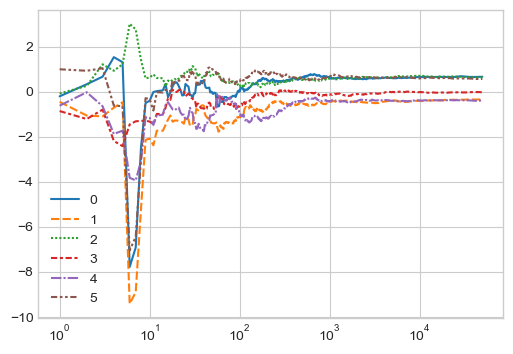

In [112]:
# plot coefficients
plot_df = pd.DataFrame.from_dict(
    {_idx: _it["coef"] for _idx, _it in models_details.items()}, orient="index"
)
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=plot_df, ax=ax)
ax.set_xscale("log")


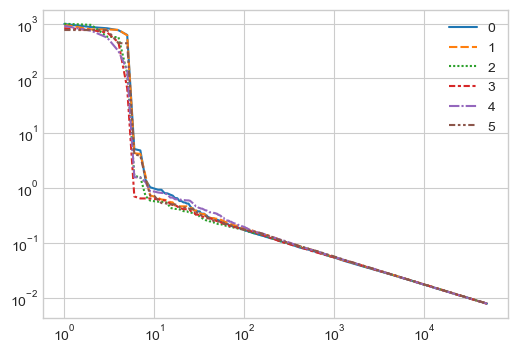

In [116]:
# plot coefficients std
plot_df = pd.DataFrame.from_dict(
    {_idx: _it["scale"] for _idx, _it in models_details.items()}, orient="index"
)
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=plot_df, ax=ax)
ax.set_xscale("log")
ax.set_yscale("log")


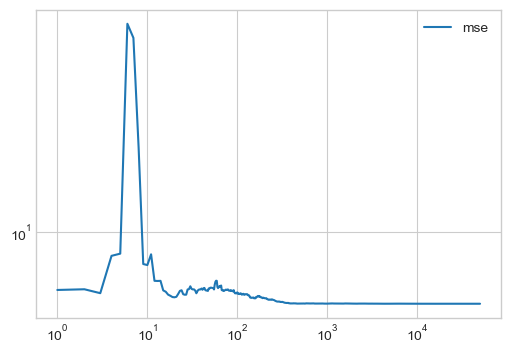

In [117]:
plot_df = pd.DataFrame.from_dict(metrics, orient="index")
fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(data=plot_df, ax=ax)
ax.set_xscale("log")
ax.set_yscale("log")


In [27]:
batch_blocks = np.linspace(0, 100, 11).astype(int)
y_train[batch_blocks[0]:batch_blocks[1]]
batch_blocks[0], batch_blocks[1]

(0, 10)

In [47]:
bayes_linear_regression = BayesLinearRegressor(number_of_features=x_train.shape[1])
# bayes_linear_regression = BayesLinearRegressor(number_of_features=x_dim)
bayes_linear_regression.fit(X=x_train, y=y_train)
bayes_linear_regression.coef_

array([ 0.65975586, -0.35204658,  0.63836231, -0.03051298, -0.3937615 ,
        0.55983785, -0.00070519, -0.00904707, -0.0295083 , -0.02780476,
        0.01056548, -0.01372422, -0.0086843 ,  0.02052915, -0.0681236 ,
        0.00507778,  0.00429317,  0.03708427, -0.02212742, -0.00204887,
       -0.02360524])

In [19]:
# X @ self.cov @ X.T

bayes_linear_regression.predict(x_test[1:5])

(array([[0.75424376],
        [0.07909032],
        [0.22977949],
        [0.15114805]]),
 array([0.01420386, 0.0167807 , 0.01992542, 0.02168406]))

In [30]:
x_test.shape
x_test_np = x_test.to_numpy()
((x_test_np[:10]@bayes_linear_regression.cov)@x_test_np[:10].T).shape

(10, 10)

In [15]:
def predict_model_partial_fit(x_train: np.array, y_train: np.array, x_test: np.array) -> [np.array, model]:
    ...


def predict_model_pair_int(
    x_train: np.array, y_train: np.array, x_test: np.array
) -> np.array:
    _model = BayesLinearRegressor(number_of_features=x_train.shape[1])
    _model.fit(x_train, y_train)
    return _model.predict(x_test)


def predict_model_base(
    x_train: np.array, y_train: np.array, x_test: np.array
) -> np.array:
    _model = BayesLinearRegressor(number_of_features=x_dim)
    _model.fit(x_train[:, :x_dim], y_train)
    return _model.predict(x_test[:, :x_dim])


def train_models(
    models: dict[str, callable],
    x_train: np.array,
    y_train: np.array,
    x_test: np.array,
) -> dict:
    "Returns coefficient arrays for different data lengths."

    y_est = {}
    for _name in models.keys():
        y_est[_name] = {}

    batch_size = 100

    for _data_filt in [100, 500, 1_000, 10_000]:
        for _name, _model in models.items():
            y_est[_name][_data_filt] = _model(
                x_train[1:_data_filt], y_train[1:_data_filt], x_test
            )
    return y_est


# y_est = train_models(
#     models={"base": predict_model_base, "pair_int": predict_model_pair_int},
#     x_train=x_train.to_numpy(),
#     y_train=y_train,
#     x_test=x_test.to_numpy(),
# )


import tqdm


def train_loop(n: int = 100_000, x_dim: int = 6, interaction_scale: float = 0.01):
    x, y, w, bias, z = gen_data(n=n, x_dim=x_dim, interaction_scale=interaction_scale)

    x_train = x[: n // 2]
    x_test = x[n // 2 :]
    y_train = y[: n // 2]
    y_test = y[n // 2 :]

    y_est = train_models(
        models={"base": predict_model_base, "pair_int": predict_model_pair_int},
        x_train=x_train.to_numpy(),
        y_train=y_train,
        x_test=x_test.to_numpy(),
    )
    _metrics = get_metrics(y_est=y_est, y_test=y_test)
    return _metrics


metrics = []
for _i in tqdm.trange(100):
    metrics.append(train_loop(n = 10_000, x_dim = 6, interaction_scale = 0.01))
metrics = pl.concat(metrics)

fig, ax = plt.subplots(figsize=(6, 4))
sns.lineplot(
    data=metrics.melt(id_vars="data_size"),
    x="data_size",
    y="value",
    hue="variable",
    ax=ax,
)
ax.set_xscale("log")
ax.set_yscale("log")
fig.show()


In [19]:
# predict_model_pair_int(x_train, y_train, x_test)

_model = BayesLinearRegressor(number_of_features=x_train.shape[1])
_model.fit(x_train, y_train)
_model.predict(x_test)


ValueError: matrices are not aligned

In [67]:

y_est = train_models(
    models={"base": predict_model_base, "pair_int": predict_model_pair_int},
    x_train=x_train.to_numpy(),
    y_train=y_train,
    x_test=x_test.to_numpy(),
)


In [66]:
y_est

{'base': {100: array([-1.1343736 , -1.15145792, -0.28862799, ..., -2.23591963,
         -0.85625119, -1.16235271]),
  500: array([-0.99140235, -0.16570416, -0.72797032, ..., -1.79946908,
         -1.08810611, -1.09239713]),
  1000: array([-1.03993013, -0.23798927, -0.78495275, ..., -2.1032829 ,
         -1.04855531, -1.12437958]),
  10000: array([-1.12517111, -0.12026678, -0.86987281, ..., -1.94547785,
         -1.20003139, -1.15545553])},
 'pair_int': {100: array([-0.78541068, -0.13654123, -1.77471937, ..., -1.78872904,
         -1.40143505, -1.63164874]),
  500: array([-1.10417026,  0.10001867, -0.95477855, ..., -2.00298781,
         -1.43533219, -1.26281016]),
  1000: array([-1.19322776, -0.19061245, -0.81566606, ..., -2.9023337 ,
         -1.20209375, -1.13392525]),
  10000: array([-1.07372452, -0.13391341, -0.906022  , ..., -2.07459191,
         -1.24894055, -1.13393753])}}